# Crime and Weather-ment

### Will certain weather conditions be statistically related to increases in crime in Louisville, Kentucky?
Reports of crime occuring from 2004 to 2020 are compared against precipitation and high and low temperatures for each day. The analyzed data spans 6210 days and covers 1,367,556 crimes occurring on those days. 


#### Notes about crime files: 
* .csv files retrieved from https://data.louisvilleky.gov/
* 'Crime_Data_2003.csv' only has ~19,000 crimes reported when years 2004-2020 range from ~71,000 to ~91,000 crime reports/year. So, 2003 was left out of the anaylsis
* 'Crime_Data_2019.csv' has reports from 2019-2021. Crimes occuring in 2021 are left out of the anaylsis.
* Crime analysis is performed on the occurence date.


#### Notes about weather file:
* .csv retrieved from https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00154958/detail
* Weather statements (ex: precipitation amounts, min temp) cannot be linked to the exact time of the crime occurence with this data.
* Precipitation amounts are in inches
* 5/27/2008 and 5/28/2008 do not have a 'PRCP' (precipitation) amount listed and are blank. 5/28/2008 lists '.02' under 'MDPR' (Multiday precipitation total). This is the only amount listed for 'MDPR' in the entire file. I added '.01' to 'PRCP' in the dataframe to 5/27/2008 and 5/28/2008 for the purposes of this analysis.   


In [275]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
%matplotlib inline

louisville_weather=pd.read_csv("data/2451549.csv") #Weather from 1-1-1997 til 2-9-2021

crime_files = ['Crime_Data_2004.csv', 'Crime_Data_2005.csv', 'Crime_Data_2006.csv','Crime_Data_2007.csv','Crime_Data_2008.csv','Crime_Data_2009.csv','Crime_Data_2010.csv','Crime_Data_2011.csv','Crime_Data_2012.csv','Crime_Data_2013.csv','Crime_Data_2014.csv','Crime_Data_2015.csv','Crime_Data_2016_39.csv','Crime_Data_2017_9.csv', 'Crime_Data_2018.csv', 'Crime_Data_2019.csv']

list_of_crime_dfs = []

for file in crime_files:
    df = pd.read_csv("data/"+file, index_col=None, header=0)
    list_of_crime_dfs.append(df)

concat_crime_df = pd.concat(list_of_crime_dfs, axis=0, ignore_index=True)

print("For the concatenated dataframe, the number of crimes listed is ", len(concat_crime_df), ". Number of unique incident numbers: ", len(concat_crime_df["INCIDENT_NUMBER"].unique()) ,". The earliest crime (an assault) was reported to have occured on 1920-11-11. Some crimes do not have an occurence date listed. Still other crimes (173) have a report date which is prior to the occurence date. For example, incident number: 80-10-047137 has DATE_REPORTED: 2006-06-23, DATE_OCCURED: 2010-06-23. This is 1,461 days before the supossed incident. Many of these crime records are only 1 day off, however, these will be removed   ")

total_counts = concat_crime_df['CRIME_TYPE'].value_counts()
total_counts


For the concatenated dataframe, the number of crimes listed is  1367556 . Number of unique incident numbers:  1122112 . The earliest crime (an assault) was reported to have occured on 1920-11-11. Some crimes do not have an occurence date listed. Still other crimes (173) have a report date which is prior to the occurence date. For example, incident number: 80-10-047137 has DATE_REPORTED: 2006-06-23, DATE_OCCURED: 2010-06-23. This is 1,461 days before the supossed incident. Many of these crime records are only 1 day off, however, these will be removed   


THEFT/LARCENY               241147
DRUGS/ALCOHOL VIOLATIONS    220742
ASSAULT                     192046
OTHER                       190194
BURGLARY                    113940
VANDALISM                   111249
VEHICLE BREAK-IN/THEFT      106142
FRAUD                        62005
MOTOR VEHICLE THEFT          56440
ROBBERY                      26469
DISTURBING THE PEACE         16633
WEAPONS                      16098
SEX CRIMES                   11113
DUI                           1580
HOMICIDE                      1404
ARSON                          354
Name: CRIME_TYPE, dtype: int64

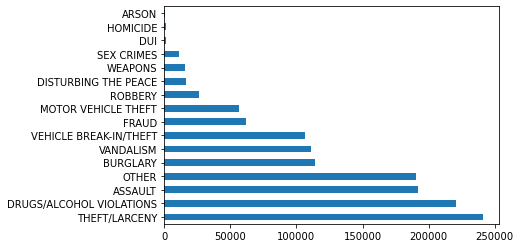

In [276]:
total_counts.plot.barh(x='Number of crimes' )

In [277]:
#####   Display all sub crimes by order of occurence  #####
# sub_counts = concat_crime_df['UOR_DESC'].value_counts()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(sub_counts)

In [278]:
##### 'Clean' concat_crime_df #####

concat_crime_df['DATE_OCCURED_NOTIME'] = concat_crime_df['DATE_OCCURED'].str.split(' ').str[0]  #add column with just the occurence time
concat_crime_df['Report-Occur-Difference']= pd.to_datetime(concat_crime_df['DATE_REPORTED'].str.split(' ').str[0]) - pd.to_datetime(concat_crime_df['DATE_OCCURED'].str.split(' ').str[0])

print("Before clean: ", len(concat_crime_df))
concat_crime_df = concat_crime_df.dropna(axis=0, subset=['DATE_OCCURED_NOTIME'])
print("After dropna: ", len(concat_crime_df))

# print("this is for the concat df:", concat_crime_df['DATE_OCCURED_NOTIME'].min(), concat_crime_df['DATE_OCCURED_NOTIME'].max(), len(concat_crime_df))

concat_crime_df=concat_crime_df[(concat_crime_df['Report-Occur-Difference']>='0 days')& (concat_crime_df['Report-Occur-Difference']<='70000 days' )]
print("After limiting by days btwn report/occur: ", len(concat_crime_df))

# & (concat_crime_df['Report-Occur-Difference']<='7 days')
# print(len(concat_crime_df))
# print(len(concat_crime_df))
# print(concat_crime_df['DATE_OCCURED_NOTIME'].count())
# exclusion_df = concat_crime_df[(concat_crime_df['DATE_OCCURED_NOTIME']<'2004-01-01') ]
# exclusion_df = concat_crime_df[(concat_crime_df['DATE_OCCURED_NOTIME']<'2004-01-01')| (concat_crime_df['DATE_OCCURED_NOTIME']>'2020-12-31')  ]
concat_crime_df=concat_crime_df[(concat_crime_df['DATE_OCCURED_NOTIME']>='2004-01-01')& (concat_crime_df['DATE_OCCURED_NOTIME']<='2020-12-31')  ]
print("only 2004-2020 : ", len(concat_crime_df))

# DATE_OCCURED_NOTIME
# concat_crime_df.sort_values(by='Report-Occur-Difference', ascending=False)
# print("this is for the exclusion df: ", exclusion_df['DATE_OCCURED_NOTIME'].min(), exclusion_df['DATE_OCCURED_NOTIME'].max(), len(exclusion_df))
# print("this is for the concat df:", concat_crime_df['DATE_OCCURED_NOTIME'].min(), concat_crime_df['DATE_OCCURED_NOTIME'].max(), len(concat_crime_df))
# exclusion_df
# print(len(concat_crime_df))


Before clean:  1367556
After dropna:  1367210
After limiting by days btwn report/occur:  1367037
only 2004-2020 :  1357129


In [279]:
# concat_crime_df.dtypes

In [280]:

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(concat_crime_df[concat_crime_df['Report-Occur-Difference']<'0 days'])
# concat_crime_df[concat_crime_df['Report-Occur-Difference']<'0 days']

In [281]:
# #Strips the time from date/time
# concat_crime_df['DATE_OCCURED_NOTIME'] = concat_crime_df['DATE_OCCURED'].str.split(' ').str[0]
# # crime_2019['DATE_OCCURED_NOTIME']
# concat_crime_df['Report-Occur-Difference']= pd.to_datetime(concat_crime_df['DATE_REPORTED'].str.split(' ').str[0]) - pd.to_datetime(concat_crime_df['DATE_OCCURED'].str.split(' ').str[0])


# concat_crime_df['DATE_OCCURED_NOTIME'] = concat_crime_df['DATE_OCCURED'].str.split(' ').str[0]  #add column with just the occurence time
# concat_crime_df['Report-Occur-Difference']= pd.to_datetime(concat_crime_df['DATE_REPORTED'].str.split(' ').str[0]) - pd.to_datetime(concat_crime_df['DATE_OCCURED'].str.split(' ').str[0])

In [282]:
# louisville_weather['PRCP'].describe()   #describe precipitation column
# louisville_weather['DATE']


In [283]:
# louisville_weather.describe()
# louisville_weather.columns

In [284]:
date_crime_count_df = louisville_weather[['DATE','PRCP','SNOW','TMAX','TMIN']].iloc[2556:8766]
date_crime_count_df['DOW'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day_name()
date_crime_count_df['DOW-N'] = pd.to_datetime(date_crime_count_df['DATE']).dt.dayofweek  #DOW-Number 0=Monday, 1=Tuesday...

date_crime_count_df['DOM'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day
date_crime_count_df['Month'] = pd.to_datetime(date_crime_count_df['DATE']).dt.month
date_crime_count_df['Year'] = pd.to_datetime(date_crime_count_df['DATE']).dt.year
date_crime_count_df['DOY-N'] = pd.to_datetime(date_crime_count_df['DATE']).dt.dayofyear
date_crime_count_df['NUMBER_OF_CRIMES'] = 0
for column in total_counts.index:  #Add a column in date_crime_count_df for all of the unique crimes in concat_crime_df['CRIME_TYPE']
    date_crime_count_df[column]=0

date_crime_count_df.head()

DATE  PRCP  SNOW  TMAX  TMIN       DOW  DOW-N  DOM  Month  Year  \
2556  2004-01-01  0.40   0.0  54.0  31.0  Thursday      3    1      1  2004   
2557  2004-01-02  0.92   0.0  62.0  49.0    Friday      4    2      1  2004   
2558  2004-01-03  0.11   0.0  66.0  60.0  Saturday      5    3      1  2004   
2559  2004-01-04  1.01   0.0  67.0  44.0    Sunday      6    4      1  2004   
2560  2004-01-05  0.10   0.0  49.0  29.0    Monday      0    5      1  2004   

      ...  VEHICLE BREAK-IN/THEFT  FRAUD  MOTOR VEHICLE THEFT  ROBBERY  \
2556  ...                       0      0                    0        0   
2557  ...                       0      0                    0        0   
2558  ...                       0      0                    0        0   
2559  ...                       0      0                    0        0   
2560  ...                       0      0                    0        0   

      DISTURBING THE PEACE  WEAPONS  SEX CRIMES  DUI  HOMICIDE  ARSON  
2556                     0        0           0    0         0      0  
2557                     0        0           0    0         0      0  
2558                     0        0           0    0         0      0  
2559                     0        0           0    0         0      0  
2560                     0        0           0    0         0      0  

[5 rows x 28 columns]

In [285]:
# date_crime_count_df[date_crime_count_df['DOY-N']==366]

In [286]:
#splits 5/28/2008 multiday precipitation amount of .02 between 5/27/2008 and 5/28/2008 and gets rid of NaN values in PRCP

date_crime_count_df.loc[4164, 'PRCP'] = .01
date_crime_count_df.loc[4165, 'PRCP'] = .01

date_crime_count_df['SNOW'] = date_crime_count_df['SNOW'].fillna(0)



In [287]:
# date_crime_count_df

In [288]:
import time
start = time.time()

def getNumCrimes(date,temp_sorted_df):
    try:   #Need try/except due to missing crime types for certain days
        return len(temp_sorted_df['DATE_OCCURED_NOTIME'].get_group((date)))
    except:
        # print("exception occurred", date, columnName)
        return 0

temp_sorted_df = concat_crime_df.groupby(['DATE_OCCURED_NOTIME'])

date_crime_count_df['NUMBER_OF_CRIMES'] = date_crime_count_df.apply(lambda x: getNumCrimes(x['DATE'],temp_sorted_df),axis=1)



def sumForEachCrimeCategory(date,temp_sorted_df, columnName):
    try:   #Need try/except due to missing crime types for certain days
        return len(temp_sorted_df["CRIME_TYPE"].get_group((date,columnName)))
    except:
        # print("exception occurred", date, columnName)
        return 0

temp_sorted_df = concat_crime_df.groupby(['DATE_OCCURED_NOTIME','CRIME_TYPE'])

listOfCrimeColumns = date_crime_count_df.columns[12:]
for columnName in listOfCrimeColumns:
    date_crime_count_df[columnName] = date_crime_count_df.apply(lambda x: sumForEachCrimeCategory(x['DATE'],temp_sorted_df, columnName),axis=1)


end = time.time()
print("The cell took: ", (end-start), "seconds to run.")


The cell took:  13.611021041870117 seconds to run.


In [289]:
# date_crime_count_df['NUMBER_OF_CRIMES'].describe()
# date_crime_count_df.columns[12:]

In [290]:
a = date_crime_count_df[date_crime_count_df['NUMBER_OF_CRIMES']==85]
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(a)

DATE  PRCP  SNOW  TMAX  TMIN     DOW  DOW-N  DOM  Month  Year  \
2914  2004-12-24   0.0   0.0  19.0   4.0  Friday      4   24     12  2004   

      DOY-N  NUMBER_OF_CRIMES  THEFT/LARCENY  DRUGS/ALCOHOL VIOLATIONS  \
2914    359                85             11                         2   

      ASSAULT  OTHER  BURGLARY  VANDALISM  VEHICLE BREAK-IN/THEFT  FRAUD  \
2914        4     15        18         12                       8      6   

      MOTOR VEHICLE THEFT  ROBBERY  DISTURBING THE PEACE  WEAPONS  SEX CRIMES  \
2914                    4        1                     2        0           2   

      DUI  HOMICIDE  ARSON  
2914    0         0      0

In [291]:
##### CHECK WORK - see if crime counts are correct in a different manner ####
# len(concat_crime_df.loc[(concat_crime_df['DATE_OCCURED_NOTIME'] == '2004-12-24') & (concat_crime_df['CRIME_TYPE'] == 'VEHICLE BREAK-IN/THEFT') ])

In [292]:
date_crime_count_df

DATE  PRCP  SNOW  TMAX  TMIN        DOW  DOW-N  DOM  Month  Year  \
2556  2004-01-01  0.40   0.0  54.0  31.0   Thursday      3    1      1  2004   
2557  2004-01-02  0.92   0.0  62.0  49.0     Friday      4    2      1  2004   
2558  2004-01-03  0.11   0.0  66.0  60.0   Saturday      5    3      1  2004   
2559  2004-01-04  1.01   0.0  67.0  44.0     Sunday      6    4      1  2004   
2560  2004-01-05  0.10   0.0  49.0  29.0     Monday      0    5      1  2004   
...          ...   ...   ...   ...   ...        ...    ...  ...    ...   ...   
8761  2020-12-27  0.00   0.0  57.0  30.0     Sunday      6   27     12  2020   
8762  2020-12-28  0.00   0.0  53.0  28.0     Monday      0   28     12  2020   
8763  2020-12-29  0.00   0.0  39.0  29.0    Tuesday      1   29     12  2020   
8764  2020-12-30  1.00   0.0  58.0  34.0  Wednesday      2   30     12  2020   
8765  2020-12-31  0.41   0.0  37.0  32.0   Thursday      3   31     12  2020   

      ...  VEHICLE BREAK-IN/THEFT  FRAUD  MOTOR VEHICLE THEFT  ROBBERY  \
2556  ...                      14     48                   14        9   
2557  ...                      17     10                    5        1   
2558  ...                      15     11                   13        5   
2559  ...                      14      2                    8        7   
2560  ...                      14      4                   11        2   
...   ...                     ...    ...                  ...      ...   
8761  ...                      18      3                   12        3   
8762  ...                      28     12                   15        6   
8763  ...                      29      9                   22        2   
8764  ...                      24      5                   15        1   
8765  ...                      20     10                   18        2   

      DISTURBING THE PEACE  WEAPONS  SEX CRIMES  DUI  HOMICIDE  ARSON  
2556                     7        4          64    1         1      0  
2557                     9        0          31    0         0      0  
2558                     3        1           2    2         0      0  
2559                     1        2           1    1         0      0  
2560                     0        1           2    0         0      0  
...                    ...      ...         ...  ...       ...    ...  
8761                     1        2           1    0         1      0  
8762                     1        9           0    0         0      1  
8763                     1        3           0    0         1      0  
8764                     0        3           0    0         2      0  
8765                     0        2           0    0         0      0  

[6210 rows x 28 columns]

In [293]:
# date_crime_count_df['DOW'] = date_crime_count_df['DOW'].astype(str)

In [294]:
# print(date_crime_count_df.dtypes)

In [295]:
# date_crime_count_df['PRCP'].describe()
zero_days = (date_crime_count_df['PRCP']==0).sum()
nonzero_days = (date_crime_count_df['PRCP']>0).sum()
print("Number of days with no precipitation: ",zero_days, " - Percentage: ", zero_days/(zero_days+nonzero_days))  # How many zeros are there
print("Number of days with some precipitation: ", nonzero_days, " - Percentage: ", nonzero_days/(zero_days+nonzero_days))
print("Number of days with snow: ", (date_crime_count_df['SNOW']>0).sum())

Number of days with no precipitation:  3890  - Percentage:  0.6264090177133655
Number of days with some precipitation:  2320  - Percentage:  0.37359098228663445
Number of days with snow:  239


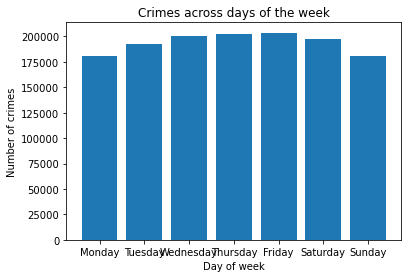

In [296]:
monday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Monday', 'NUMBER_OF_CRIMES'].sum()
tuesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Tuesday', 'NUMBER_OF_CRIMES'].sum()
wednesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Wednesday', 'NUMBER_OF_CRIMES'].sum()
thursday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Thursday', 'NUMBER_OF_CRIMES'].sum()
friday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Friday', 'NUMBER_OF_CRIMES'].sum()
saturday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Saturday', 'NUMBER_OF_CRIMES'].sum()
sunday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Sunday', 'NUMBER_OF_CRIMES'].sum()


x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DOW = [monday_crimes, tuesday_crimes, wednesday_crimes, thursday_crimes, friday_crimes, saturday_crimes, sunday_crimes]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, DOW)
plt.xlabel("Day of week")
plt.ylabel("Number of crimes")
plt.title("Crimes across days of the week")

plt.xticks(x_pos, x)

plt.show()


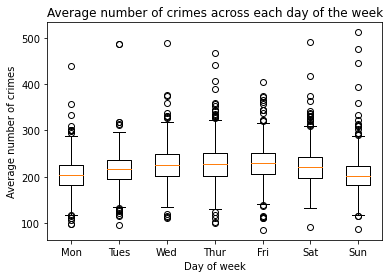

In [297]:
DOW=[]
DOWList=['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday', 'Sunday']
for x in DOWList:
    DOW.append(date_crime_count_df.loc[date_crime_count_df['DOW'] == x, 'NUMBER_OF_CRIMES'])
# print(DOWList)
# averageCrimesOnDOM= plt.boxplot(DOW)
# print(averageCrimesOnDOM)
plt.ylabel("Average number of crimes")
plt.xlabel("Day of week")
plt.title("Average number of crimes across each day of the week")

averageCrimesOnDOM =plt.boxplot(DOW, labels=['Mon', 'Tues','Wed', 'Thur','Fri','Sat', 'Sun'])

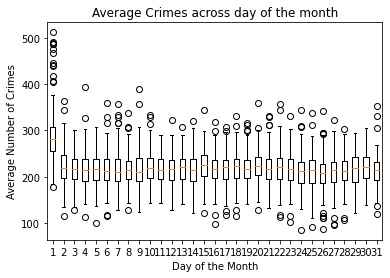

In [298]:
DOM=[]
for x in range(1,32):
    DOM.append(date_crime_count_df.loc[date_crime_count_df['DOM'] == x, 'NUMBER_OF_CRIMES'])

plt.ylabel("Average Number of Crimes")
plt.xlabel("Day of the Month")
plt.title("Average Crimes across day of the month")


averageCrimesOnDOM= plt.boxplot(DOM)


#Will we still get the same unequal distribution when we limit large differences in report vs occurrence dates



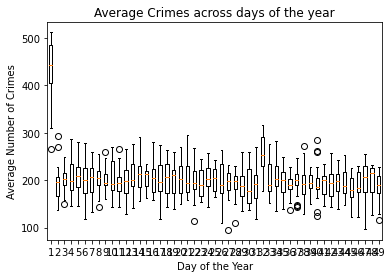

In [299]:
DOY=[]
for x in range(1,50):
    DOY.append(date_crime_count_df.loc[date_crime_count_df['DOY-N'] == x, 'NUMBER_OF_CRIMES'])

plt.ylabel("Average Number of Crimes")
plt.xlabel("Day of the Year")
plt.title("Average Crimes across days of the year")


averageCrimesOnDOM= plt.boxplot(DOY)


#Will we still get the same unequal distribution when we limit large differences in report vs occurrence dates


[71006, 77367, 83882, 90809, 85875, 77990, 82994, 85936, 81212, 76951, 77365, 79559, 83708, 81538, 72750, 68506]
90809


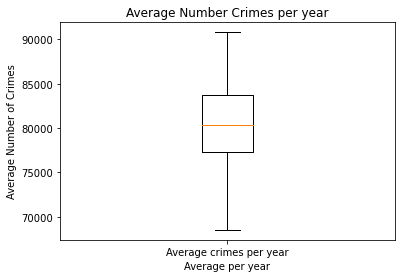

In [300]:
Year=[]
yearList=[2004,2005,2006,2007,2008,2009,2010,2011,2012, 2013,2014,2015,2016,2017,2019,2020]
# yearList=[2016,2017,2018,2019,2020]
for x in yearList:
    Year.append(date_crime_count_df.loc[date_crime_count_df['Year'] == x, 'NUMBER_OF_CRIMES'].sum())

print(Year)
print(max(Year))

plt.ylabel("Average Number of Crimes")
plt.xlabel("Average per year")
plt.title("Average Number Crimes per year")

averageCrimesOnYear= plt.boxplot(Year,labels=['Average crimes per year'])



# plt.xlim(len(yearList))
# CrimesPerYear = plt.bar(x=len(yearList),height=max(yearList))

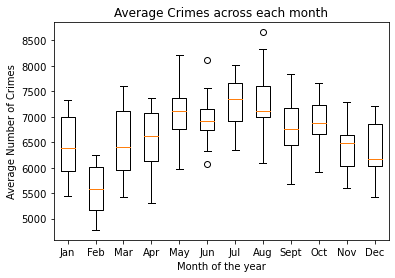

In [301]:

MOY=[]
for month in range(1,13):
    monthgroup=[]
    for year in yearList:
        monthgroup.append(date_crime_count_df.loc[(date_crime_count_df['Month'] == month) & (date_crime_count_df['Year'] == year), 'NUMBER_OF_CRIMES'].sum())

    MOY.append(monthgroup)
# z=0
# for x in MOY:
#     for y in x:
#         z+=y
# print(z)
plt.ylabel("Average Number of Crimes")
plt.xlabel("Month of the year")
plt.title("Average Crimes across each month")
averageCrimesOnMOY= plt.boxplot(MOY,labels=['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug','Sept','Oct','Nov','Dec'])



####
#### .00-.19 “very weak”
#### .20-.39 “weak”
#### .40-.59 “moderate”
#### .60-.79 “strong”
#### .80-1.0 “very strong”


In [302]:
colors=['red','blue','green','black','yellow','purple','orange']
print(colors[random.randint(0,len(colors))])

orange


NUMBER_OF_CRIMES and TMIN : Correlation coeffient 0.3281 . p value 9.322226782542457e-156
      
NUMBER_OF_CRIMES and TMAX : Correlation coeffient 0.3471 . p value 2.4707899383465224e-175
      
THEFT/LARCENY and TMIN : Correlation coeffient 0.2496 . p value 7.848020474164531e-89
      
THEFT/LARCENY and TMAX : Correlation coeffient 0.2468 . p value 7.904472936056151e-87
      
ASSAULT and TMIN : Correlation coeffient 0.2546 . p value 1.86539902038664e-92
      
ASSAULT and TMAX : Correlation coeffient 0.2624 . p value 2.4363008676498555e-98
      
BURGLARY and TMIN : Correlation coeffient 0.2109 . p value 2.211057200254354e-63
      
BURGLARY and TMAX : Correlation coeffient 0.2058 . p value 2.1399315146939948e-60
      
VANDALISM and TMIN : Correlation coeffient 0.2343 . p value 3.4907112533761423e-78
      
VANDALISM and TMAX : Correlation coeffient 0.2428 . p value 5.318284594058995e-84
      
VEHICLE BREAK-IN/THEFT and TMIN : Correlation coeffient 0.2613 . p value 1.93965378517593

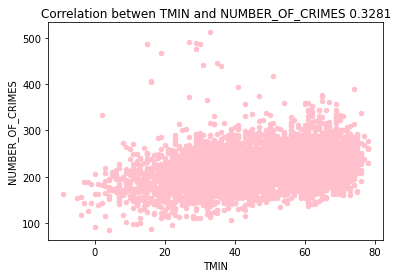

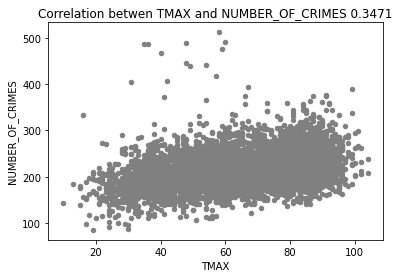

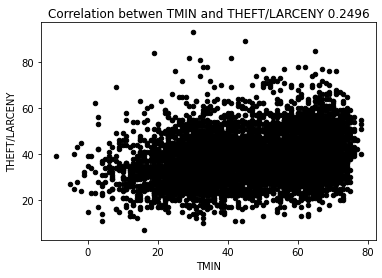

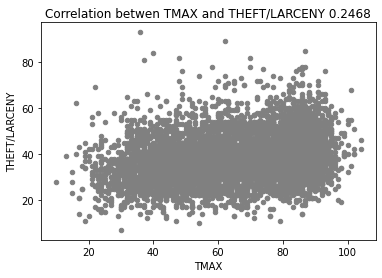

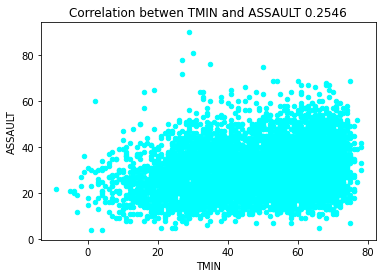

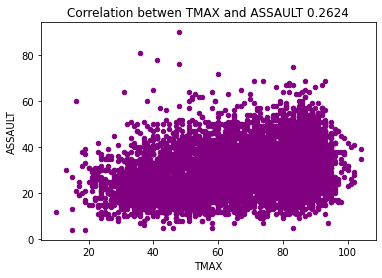

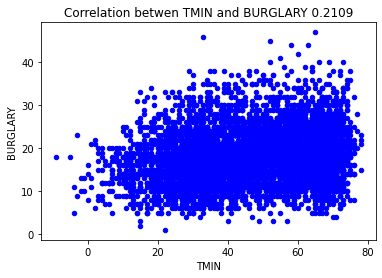

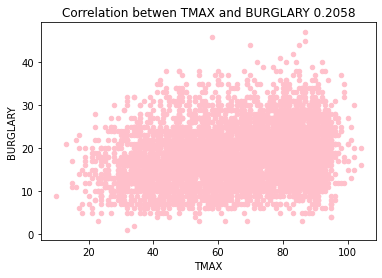

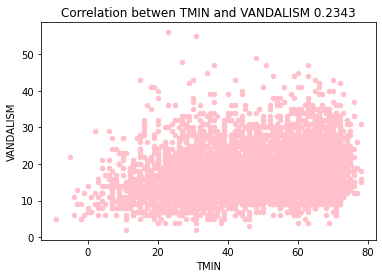

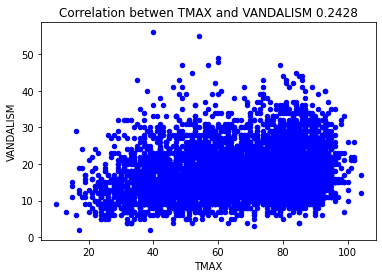

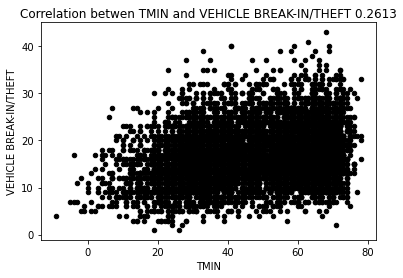

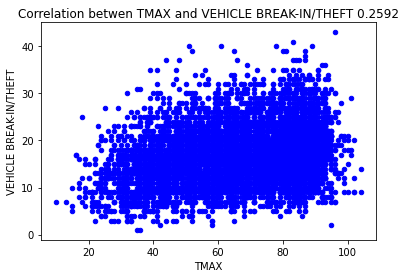

In [303]:
colors=['red','blue','green','black','yellow','purple','orange','aqua','pink','grey']
for columnName in date_crime_count_df.columns[11:]:
    for item in ['TMIN', 'TMAX', 'PRCP', 'SNOW']:
        a = stats.pearsonr(date_crime_count_df[item],date_crime_count_df[columnName])
        if abs(a[0])>.2:
            print(columnName, "and", item, ":" , "Correlation coeffient", round(a[0],4), ". p value", a[1])
            print("      ")
            date_crime_count_df.plot(x=item, y=columnName, kind='scatter', color = colors[random.randint(0,len(colors)-1)], title="Correlation betwen "+item+" and "+columnName + " "+ str(round(a[0],4)) )

            

In [304]:
concat_crime_df['Report-Occur-Difference'].value_counts().head(60)

0 days     945814
1 days     170185
2 days      55502
3 days      29733
4 days      18735
5 days      13066
6 days       9849
7 days       8986
8 days       6824
9 days       5016
10 days      4441
11 days      3717
14 days      3593
12 days      3336
13 days      2912
15 days      2892
16 days      2206
17 days      2035
18 days      1883
21 days      1755
20 days      1719
31 days      1694
19 days      1667
22 days      1624
30 days      1279
23 days      1249
24 days      1162
28 days      1160
25 days      1145
32 days      1142
26 days      1125
27 days      1085
29 days      1037
33 days       844
36 days       832
35 days       816
34 days       763
38 days       713
37 days       670
39 days       619
42 days       602
41 days       590
40 days       567
43 days       563
61 days       557
44 days       512
45 days       500
49 days       483
46 days       479
48 days       477
47 days       451
50 days       436
62 days       432
52 days       426
51 days       409
57 days   

In [305]:
XDaysPast = 0

dayOfMonth='05'
for x in range(0,22):
    CrimesXDaysPast = len(concat_crime_df[concat_crime_df['Report-Occur-Difference']==str(XDaysPast)+' days'])
    CrimesXDaysPastOnFirst = len(concat_crime_df[(concat_crime_df['Report-Occur-Difference']==str(XDaysPast)+' days')& (concat_crime_df['DATE_OCCURED_NOTIME'].str.split('-').str[2]==dayOfMonth)]) 

    print(round(CrimesXDaysPastOnFirst/CrimesXDaysPast*100,2), "% of crimes", CrimesXDaysPastOnFirst,'/',CrimesXDaysPast, "happen on", dayOfMonth,"of the month if ", XDaysPast, "days between occurence and report. Expected: 1/30 = ~3.3%")
    XDaysPast+=15
# concat_crime_df.to_csv('out.csv', index=False)

3.26 % of crimes 30868 / 945814 happen on 05 of the month if  0 days between occurence and report. Expected: 1/30 = ~3.3%
3.84 % of crimes 111 / 2892 happen on 05 of the month if  15 days between occurence and report. Expected: 1/30 = ~3.3%
3.36 % of crimes 43 / 1279 happen on 05 of the month if  30 days between occurence and report. Expected: 1/30 = ~3.3%
3.0 % of crimes 15 / 500 happen on 05 of the month if  45 days between occurence and report. Expected: 1/30 = ~3.3%
1.98 % of crimes 7 / 354 happen on 05 of the month if  60 days between occurence and report. Expected: 1/30 = ~3.3%
1.57 % of crimes 4 / 255 happen on 05 of the month if  75 days between occurence and report. Expected: 1/30 = ~3.3%
0.46 % of crimes 1 / 218 happen on 05 of the month if  90 days between occurence and report. Expected: 1/30 = ~3.3%
1.2 % of crimes 2 / 167 happen on 05 of the month if  105 days between occurence and report. Expected: 1/30 = ~3.3%
0.0 % of crimes 0 / 116 happen on 05 of the month if  120 day

In [306]:
XDaysPast = 0
checkDate='-01-09'
for x in range(0,40):
    CrimesXDaysPast = len(concat_crime_df[concat_crime_df['Report-Occur-Difference']>=str(XDaysPast)+' days'])
    CrimesXDaysPastOnFirst = len(concat_crime_df[(concat_crime_df['Report-Occur-Difference']>=str(XDaysPast)+' days')& (concat_crime_df['DATE_OCCURED_NOTIME'].str.contains(checkDate))]) 

    print(round(CrimesXDaysPastOnFirst/CrimesXDaysPast*100,2), "% of crimes",  CrimesXDaysPastOnFirst,'/',CrimesXDaysPast,  "happen on", checkDate, "if ", XDaysPast, "OR MORE days between occurence and report. Expected: 1/365 = ~.27%")
    XDaysPast+=30
#some days are clearly favored


0.25 % of crimes 3420 / 1357129 happen on -01-09 if  0 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.22 % of crimes 112 / 51676 happen on -01-09 if  30 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.21 % of crimes 69 / 33243 happen on -01-09 if  60 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.19 % of crimes 48 / 25060 happen on -01-09 if  90 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.22 % of crimes 44 / 20301 happen on -01-09 if  120 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.23 % of crimes 41 / 17473 happen on -01-09 if  150 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.26 % of crimes 39 / 15263 happen on -01-09 if  180 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.27 % of crimes 36 / 13432 happen on -01-09 if  210 OR MORE days between occurence and report. Expected: 1/365 = ~.27%
0.29 % of crimes 35 / 12109 happen on -0